In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import copy
from scipy.stats import multivariate_normal

%matplotlib inline

In [2]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

In [3]:
def compute_responsibilities(data, weights, means, covariances):
    '''E-step: compute responsibilities, given the current parameters'''
    num_data = len(data)
    num_clusters = len(means)
    resp = np.zeros((num_data, num_clusters))
    
    # Update resp matrix so that resp[i,k] is the responsibility of cluster k for data point i.
    # Hint: To compute likelihood of seeing data point i given cluster k, use multivariate_normal.pdf.
    for i in range(num_data):
        for k in range(num_clusters): 
            resp[i, k] = multivariate_normal.pdf(data[i], mean=means[k], cov=covariances[k])*weights[k]
    
    # Add up responsibilities over each data point and normalize
    row_sums = resp.sum(axis=1)[:, np.newaxis]
    resp = resp / row_sums
    
    return resp

In [4]:
resp = compute_responsibilities(data=np.array([[1.,2.],[-1.,-2.]]), weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])

if resp.shape==(2,2) and np.allclose(resp, np.array([[0.10512733, 0.89487267], [0.46468164, 0.53531836]])):
    print ('Checkpoint passed!')
else:
    print ('Check your code again.')

Checkpoint passed!


In [5]:
def compute_soft_counts(resp):
    # Compute the total responsibility assigned to each cluster, which will be useful when 
    # implementing M-steps below. In the lectures this is called N^{soft}
    counts = np.sum(resp, axis=0)
    return counts

In [6]:
def compute_weights(counts):
    num_clusters = len(counts)
    weights = [0.] * num_clusters
    N = np.sum(counts)  
    
    for k in range(num_clusters):
        # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
        # HINT: compute # of data points by summing soft counts. 
        weights[k] = counts[k]/N

    return weights

In [7]:
resp = compute_responsibilities(data=np.array([[1.,2.],[-1.,-2.],[0,0]]), weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
weights = compute_weights(counts)

print('Counts: %s' % counts)
print ('Weights: %s' % weights)

if np.allclose(weights, [0.27904865942515705, 0.720951340574843]):
    print('Checkpoint passed!')
else:
    print('Check your code again.')

Counts: [0.83714598 2.16285402]
Weights: [0.27904865942515705, 0.720951340574843]
Checkpoint passed!


In [8]:
def compute_means(data, resp, counts):
    num_clusters = len(counts)
    num_data = len(data)
    means = [np.zeros(len(data[0]))] * num_clusters 
    
    for k in range(num_clusters):
        # Update means for cluster k using the M-step update rule for the mean variables.
        # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
        weighted_sum = 0.
        
        for i in range(num_data): 
            weighted_sum += resp[i][k] * data[i]
        
        nk_soft = counts[k]
        means[k] = (1/nk_soft)*weighted_sum

    return means

In [9]:
data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = compute_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
means = compute_means(data_tmp, resp, counts)

if np.allclose(means, np.array([[-0.6310085, -1.262017], [0.25140299, 0.50280599]])):
    print('Checkpoint passed!')
else:
    print('Check your code again.')

Checkpoint passed!


In [10]:
def compute_covariances(data, resp, counts, means):
    num_clusters = len(counts)
    num_dim = len(data[0])
    num_data = len(data)
    covariances = [np.zeros((num_dim,num_dim))] * num_clusters
    
    for k in range(num_clusters):
        # Update covariances for cluster k using the M-step update rule for covariance variables.
        # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
        weighted_sum = np.zeros((num_dim, num_dim))
        for i in range(num_data):
            # (Hint: Use np.outer on the data[i] and this cluster's mean) 
            xi,uk = data[i], means[k]
            weighted_sum += resp[i][k]* np.outer(xi-uk,xi-uk)
        
        nk_soft = counts[k]
        covariances[k] =(1/nk_soft)*weighted_sum

    return covariances

In [11]:
data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = compute_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
means = compute_means(data_tmp, resp, counts)
covariances = compute_covariances(data_tmp, resp, counts, means)

if np.allclose(covariances[0], np.array([[0.60182827, 1.20365655], [1.20365655, 2.4073131]])) and \
    np.allclose(covariances[1], np.array([[ 0.93679654, 1.87359307], [1.87359307, 3.74718614]])):
    print('Checkpoint passed!')
else:
    print('Check your code again.')

Checkpoint passed!


In [12]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for it in range(maxiter):
        if it % 5 == 0:
            print("Iteration %s" % it)
        
        # E-step: compute responsibilities
        resp = compute_responsibilities(data, weights, means, covariances)

        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        # implementing M-steps below. In the lectures this is called N^{soft}
        counts = compute_soft_counts(resp)
        
        # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k. 
        weights = compute_weights(counts)
        
        # Update means for cluster k using the M-step update rule for the mean variables.
        # This will assign the variable means[k] to be our estimate for \hat{\mu}_k. 
        means = compute_means(data, resp, counts)
        
        # Update covariances for cluster k using the M-step update rule for covariance variables.
        # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k. 
        covariances = compute_covariances(data, resp, counts, means)
        
        # Compute the loglikelihood at this iteration 
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if it % 5 != 0:
        print("Iteration %s" % it)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

In [13]:
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

In [14]:
# Model parameters
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)
print( data[:5])

[array([0.31845368, 5.03182099]), array([1.45029339, 2.15717573]), array([1.02645431, 4.76042375]), array([ 5.23493625, -0.81138851]), array([ 4.65710743, -0.08532351])]


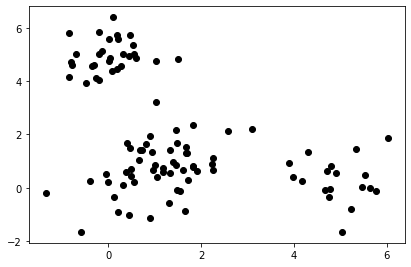

In [15]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [16]:
data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = compute_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
means = compute_means(data_tmp, resp, counts)

if np.allclose(means, np.array([[-0.6310085, -1.262017], [0.25140299, 0.50280599]])):
    print ('Checkpoint passed!')
else:
    print('Check your code again.')

Checkpoint passed!


In [17]:
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights) 
# print results

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


In [18]:
print("weights: %s"%results['weights'] )
print( "\nQ1: weight that EM assigns to the first component: %s"% round(results['weights'][0],3))

weights: [0.3007102300609824, 0.17993710074247016, 0.5193526691965474]

Q1: weight that EM assigns to the first component: 0.301


In [19]:
print ("covariance: %s" % results['covs'])
print ("\nQ3: the covariance EM assigns to the third component (1st dimension): %s"% round(results['covs'][2][0][0],3))

covariance: [array([[0.2932614 , 0.05048455],
       [0.05048455, 0.35281537]]), array([[ 0.3556437 , -0.01494875],
       [-0.01494875,  0.66695025]]), array([[0.67114992, 0.33058965],
       [0.33058965, 0.90429724]])]

Q3: the covariance EM assigns to the third component (1st dimension): 0.671


In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [26]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

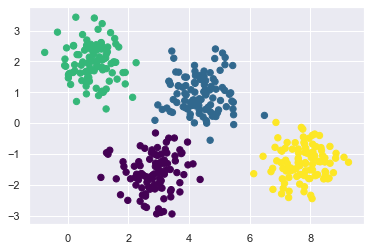

In [40]:
from sklearn.mixture import GaussianMixture
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full').fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [41]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.537 0.    0.463]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [1.    0.    0.    0.   ]]


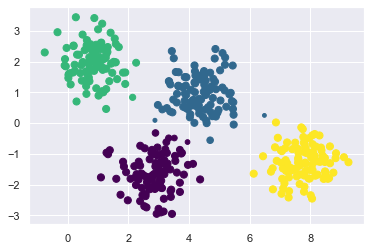

In [42]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

In [55]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

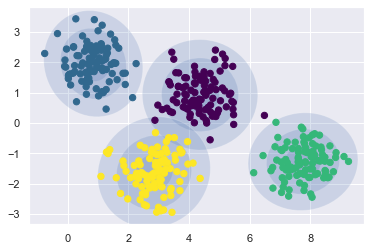

In [56]:
gmm = mixture.GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

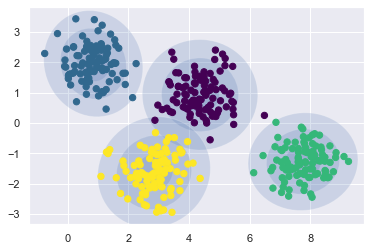

In [58]:
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X)

# GMM as Density Estimation

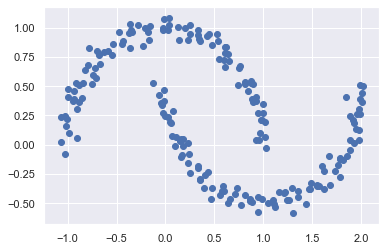

In [60]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

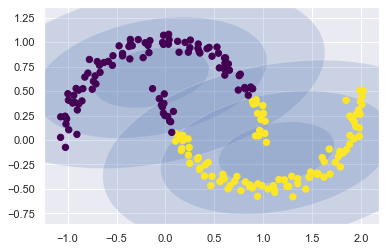

In [61]:
gmm2 = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

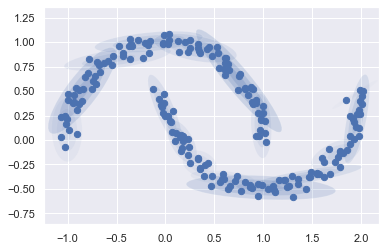

In [62]:
gmm16 = mixture.GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

C:\Users\Asyia\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


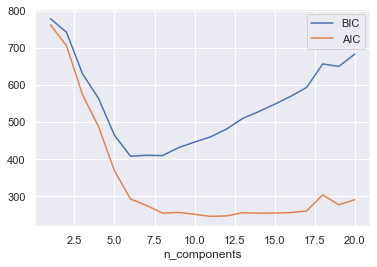

In [66]:
n_components = np.arange(1, 21)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [67]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

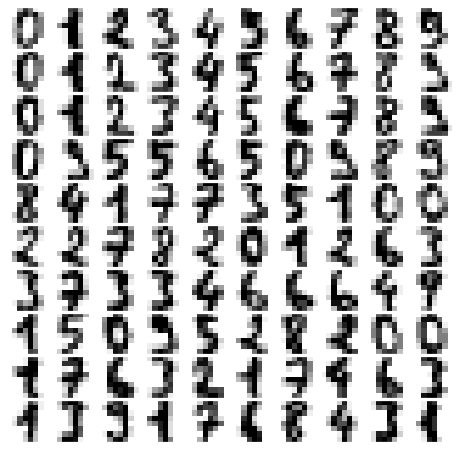

In [68]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

In [53]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

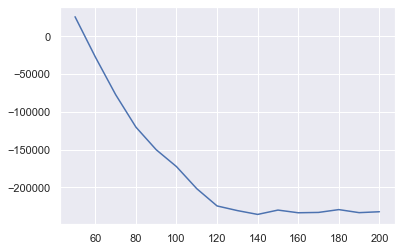

In [69]:
n_components = np.arange(50, 210, 10)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [73]:
gmm = mixture.GaussianMixture(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True
